# 🛡️ Arquitectura del Modelo de Detección de Anomalías: Enfoque Híbrido Avanzado
Para abordar el reto de identificar irregularidades en más de 30 millones de registros inmobiliarios heterogéneos, superando las limitaciones de la calidad de datos y la falta de etiquetas de fraude, se diseñó una arquitectura de detección híbrida. Esta combina la precisión de la estadística robusta, la validación de negocio (IGAC) y la capacidad de descubrimiento de la Inteligencia Artificial.

## 1. **Ingeniería de Características (Feature Engineering)**
La selección de variables trascendió los datos crudos, generando indicadores matemáticos diseñados para aislar el comportamiento anómalo:

A. **Variables Base y Validación Exógena**
- **VALOR y DINÁMICA_INMOBILIARIA (Validación de Negocio):** Se integró la clasificación experta del IGAC (Dinámica=1 para mercado, 0 para administrativo) para distinguir entre transacciones comerciales reales y trámites burocráticos. Esto permitió limpiar el ruido estadístico de millones de registros.

- **COUNT_DE y COUNT_A (Análisis de Red):** Mide la fragmentación. Un alto número de otorgantes o adquirientes alerta sobre loteos ilegales, falsa tradición o estructuras de testaferrato.

- **CONTEO_LOCAL (Rareza del Acto):** Mide la frecuencia de un tipo de acto jurídico en un municipio específico. Permite detectar actos "exóticos" o únicos en zonas rurales.

- **FECHA_APERTURA_INCONSISTENTE:** Penaliza la falta de trazabilidad histórica (calidad de datos).

B. **Transformaciones Avanzadas (Estadística Robusta)**
Dado que los precios inmobiliarios no siguen una distribución normal y presentan valores extremos (outliers), se implementaron técnicas resistentes:

1. **`VALOR_LOG` (Normalización Logarítmica):**

- **Lógica:** Transformación log1p para comprimir la escala de precios, permitiendo comparar transacciones de interés social y grandes megaproyectos en el mismo espacio vectorial sin sesgos.

2. **`Z_SCORE_ROBUSTO` (Contextualización Geoespacial):**

- **La Innovación:** A diferencia del Z-Score tradicional (Media/Desviación), este modelo utiliza la Mediana y el Rango Intercuartílico (IQR) calculados por Municipio y Tipo de Acto Jurídico.

- **Impacto:** Al usar la Mediana, el modelo es inmune a los valores extremos corruptos. Una venta de $0 pesos se compara contra la mediana real del mercado local, generando una alerta estadística inmediata (Z-Score negativo extremo) sin necesidad de filtros manuales.

## 2. **Estrategia de Detección: Defensa en Profundidad**
El sistema no depende de un solo criterio. Utiliza un enfoque de capas para categorizar el riesgo:

**Capa 1:** Reglas Forenses y Calidad de Datos (Hard Rules)
Utiliza lógica de negocio estricta para clasificar hallazgos de alta certeza.

- **Detección de Calidad de Datos:** Identifica trámites administrativos (Dinámica 0, como cancelaciones o aclaraciones) que presentan valores comerciales superiores a $10.000.000 COP, excluyendo actos legítimos (Lista blanca: Construcciones, Resciliaciones). Revela "suciedad" en la base de datos pública.

- **Detección de Crimen Financiero** Se enfoca exclusivamente en actos de COMPRAVENTA (Dinámica 1).

- **Lavado de Activos:** Transacciones con un Z-Score Robusto ≥ 5.0 (Precios estadísticamente imposibles para el sector).

- **Evasión Fiscal:** Transacciones con un Z-Score Robusto ≤ -5.0 (Precios irrisorios comparados con el mercado local).

- **Riesgo Financiero:** Identifica Hipotecas o Embargos con sobreprecios extremos (Z ≥ 5), indicativos de fraude bancario o simulación de pasivos.

**Capa 2: Inteligencia Artificial (Isolation Forest)**
Captura lo que las reglas no ven. Se entrenó un modelo no supervisado Isolation Forest con las variables transformadas.

- **Calibración Científica:** El umbral de contaminación no fue arbitrario. Se determinó mediante el Método del Codo (Elbow Method) y análisis de sensibilidad sobre los Scores de Anomalía, - fijando el corte en el Top ~1% de los datos más raros.

- **Objetivo:** Detectar fraude estructural. Encuentra transacciones con precios "normales" (Z-Score bajo) pero que son anómalas por su combinación de actores, fechas, ubicación y rareza del acto jurídico.

**Capa 3: Consolidación y Taxonomía**
El resultado final no es binario, sino descriptivo. Se fusionan los hallazgos de las capas anteriores para etiquetar cada anomalía con su causa raíz, facilitando la auditoría:

   - `Valor atípico alto` / `Valor atípico bajo`

   - `Patrón atípico IA` (Detectado exclusivamente por el algoritmo)

   - `Posible evasión fiscal` / `Posible lavado de activos`

**Resultado:** Un sistema robusto que minimiza falsos positivos al contextualizar los precios, pero maximiza la detección de fraudes complejos gracias al aprendizaje de máquina.

# Preparación del entorno

In [2]:
# Necesario para importar módulos desde el directorio raíz

import sys
import os

ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(ROOT)

In [3]:
# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest

# Local application imports
from src.data_loader import obtener_datos_pandas

# Obtención de datos

In [3]:
# Se obtienen los datos que fueron previamente procesados en Databricks

sql = """
SELECT *
FROM default.data_modelo_anomalias_transaccionales
"""

datos_modelo = obtener_datos_pandas(sql)

In [4]:
# Vistazo rápido a los datos

datos_modelo.head()

,NOMBRE_NATUJUR,PK,VALOR,YEAR_RADICA,PREDIOS_NUEVOS,COUNT_DE,COUNT_A,Dinámica_Inmobiliaria,FECHA_APERTURA_INCONSISTENTE,VALOR_LOG,CONTEO_LOCAL,Z_SCORE_ROBUSTO
0,INICIACIÓN PROCESO DE CLARIFICACIÓN DE LA PROP...,13001-060-097109-00004-00936-2017,0.0,2017,0,1,0,1,1,0.0,4624,0.000000
1,CANCELACIÓN PROVIDENCIA JUDICIAL,13001-060-097109-00005-00841-2018,0.0,2018,0,1,0,0,1,0.0,7699,0.000000
2,CANCELACIÓN PROVIDENCIA ADMINISTRATIVA,13001-060-097109-00006-00842-2021,0.0,2021,0,1,0,0,1,0.0,13254,0.000000
3,CANCELACIÓN POR VOLUNTAD DE LAS PARTES,13001-060-097110-00013-00843-2017,0.0,2017,0,1,1,0,1,0.0,66640,-1.229622
4,HIPOTECA ABIERTA SIN LIMITE DE CUANTIA,13001-060-097110-00014-00219-2017,0.0,2017,0,1,1,1,1,0.0,54370,0.000000


In [5]:
# Información de los datos

datos_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30903248 entries, 0 to 30903247
Data columns (total 12 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   NOMBRE_NATUJUR                object 
 1   PK                            object 
 2   VALOR                         float64
 3   YEAR_RADICA                   int64  
 4   PREDIOS_NUEVOS                int64  
 5   COUNT_DE                      int64  
 6   COUNT_A                       int64  
 7   Dinámica_Inmobiliaria         object 
 8   FECHA_APERTURA_INCONSISTENTE  int64  
 9   VALOR_LOG                     float64
 10  CONTEO_LOCAL                  int64  
 11  Z_SCORE_ROBUSTO               float64
dtypes: float64(3), int64(6), object(3)
memory usage: 2.8+ GB


# Enfoque con inteligencia artificial

## Alimentar el modelo

In [6]:
# Se obtienen las características para alimentar el modelo

features_modelo = datos_modelo.columns.tolist()
features_modelo.remove('PK')
features_modelo.remove('VALOR')
features_modelo.remove('NOMBRE_NATUJUR')

In [7]:
conteo_z_extremo = sum(datos_modelo['Z_SCORE_ROBUSTO'] > 3.5) + sum(datos_modelo['Z_SCORE_ROBUSTO'] < -3.5)

porcentaje_contaminacion = conteo_z_extremo / datos_modelo.shape[0]
print(f"Porcentaje de contaminación estimado: {porcentaje_contaminacion * 100:.4f}%")

Porcentaje de contaminación estimado: 1.7267%


In [8]:
print("Iniciando entrenamiento del Isolation Forest...")

iso_forest = IsolationForest(
    n_estimators=200, 
    contamination='auto', # Se estima automáticamente inicialmente para establecer un umbral posteriormente haciendo el método de codo
    max_samples='auto',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

iso_forest.fit(datos_modelo[features_modelo])

Iniciando entrenamiento del Isolation Forest...


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:   29.9s remaining:  2.5min
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   32.0s finished


,n_estimators,200
,max_samples,'auto'
,contamination,'auto'
,max_features,1.0
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,1
,warm_start,False


In [9]:
print("Calculando scores y etiquetas de anomalías...")

datos_modelo['IF_LABEL'] = iso_forest.predict(datos_modelo[features_modelo])
datos_modelo['IF_SCORE'] = iso_forest.decision_function(datos_modelo[features_modelo])

Calculando scores y etiquetas de anomalías...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   47.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   47.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   47.7s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   47.9s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   47.6s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   47.8s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   46.4s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   46.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.7s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks    

In [10]:
# Resultados del modelo, los valores de IF_LABEL son -1 para anomalías y 1 para normales

datos_modelo['IF_LABEL'].value_counts()

IF_LABEL
 1    24014266
-1     6888982
Name: count, dtype: int64

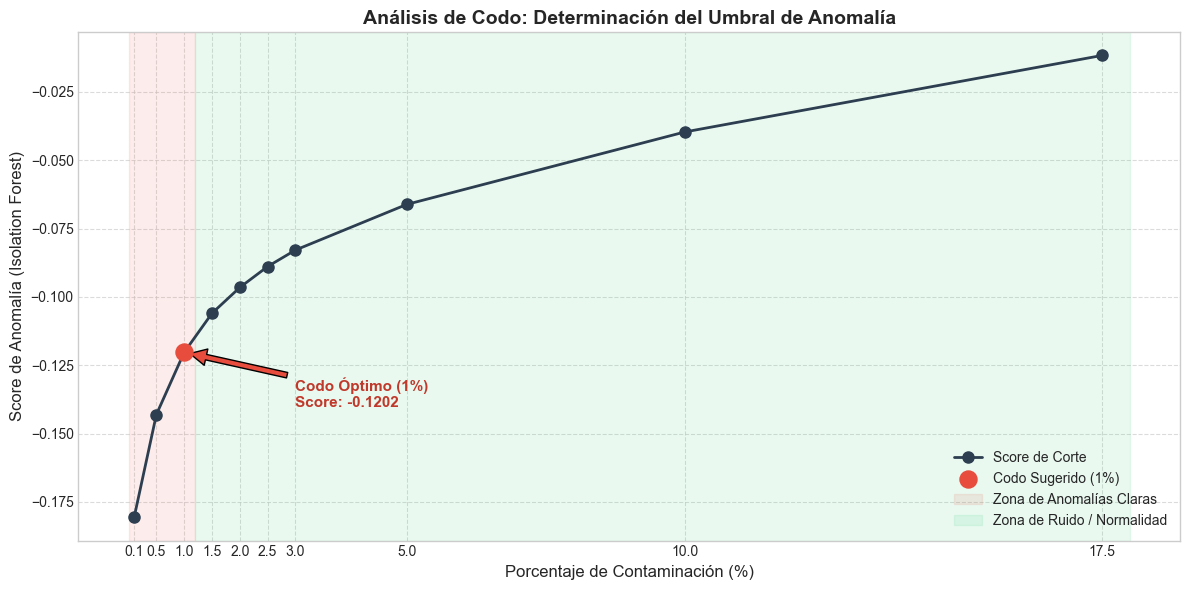

In [11]:
# Se revisan los percentiles de los scores que entregó el modelo para definir umbrales de corte con el método de codo

# 1. Calculamos los datos exactos
percentiles = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 5, 10, 17.5]
scores = [np.percentile(datos_modelo['IF_SCORE'], p) for p in percentiles]

# Creamos un DF temporal para graficar fácil
df_plot = pd.DataFrame({'Percentil': percentiles, 'Score': scores})

# 2. Configuración de la Gráfica
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid') # Estilo limpio

# Trazamos la línea principal con marcadores
plt.plot(df_plot['Percentil'], df_plot['Score'], 
         marker='o', linestyle='-', color='#2c3e50', linewidth=2, markersize=8, label='Score de Corte')

# 3. Anotación del codo sugerido (1%)
score_1pct = df_plot[df_plot['Percentil'] == 1]['Score'].values[0]

plt.scatter([1], [score_1pct], color='#e74c3c', s=150, zorder=5, label='Codo Sugerido (1%)')
plt.annotate(f'Codo Óptimo (1%)\nScore: {score_1pct:.4f}', 
             xy=(1, score_1pct), 
             xytext=(3, score_1pct - 0.02),
             arrowprops=dict(facecolor='#e74c3c', shrink=0.05),
             fontsize=11, fontweight='bold', color='#c0392b')

# 4. Decoración para interpretación
plt.title('Análisis de Codo: Determinación del Umbral de Anomalía', fontsize=14, fontweight='bold')
plt.xlabel('Porcentaje de Contaminación (%)', fontsize=12)
plt.ylabel('Score de Anomalía (Isolation Forest)', fontsize=12)

# Añadimos zonas de color para explicar
plt.axvspan(0, 1.2, color='#e74c3c', alpha=0.1, label='Zona de Anomalías Claras')
plt.axvspan(1.2, 18, color='#2ecc71', alpha=0.1, label='Zona de Ruido / Normalidad')

# Ajustes de ejes
plt.xticks(percentiles) # Mostrar todos los percentiles en el eje X
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

Se observa que curva comienza a aplanarse a partir del percentil 1, por lo que la contaminación óptima es del 1% y su score -0.1202

In [12]:
corte_1_porciento = np.percentile(datos_modelo['IF_SCORE'], 1)

print(f"Umbral de corte para el 1%: {corte_1_porciento}")

Umbral de corte para el 1%: -0.12024942801109761


In [13]:
datos_modelo['IF_LABEL'] = np.where(datos_modelo['IF_SCORE'] <= corte_1_porciento, -1, 1)

In [14]:
cond_anomalia = datos_modelo['IF_LABEL'] == -1

In [15]:
# Estadísticas de las transacciones marcadas como anómalas

datos_modelo[cond_anomalia].describe()

,VALOR,YEAR_RADICA,PREDIOS_NUEVOS,COUNT_DE,COUNT_A,FECHA_APERTURA_INCONSISTENTE,VALOR_LOG,CONTEO_LOCAL,Z_SCORE_ROBUSTO,IF_LABEL,IF_SCORE
count,3.091770e+05,309177.000000,309177.000000,309177.000000,309177.000000,309177.000000,309177.000000,309177.000000,309177.000000,309177.0,309177.000000
mean,1.155807e+10,2021.224383,0.233785,3.011663,3.923190,0.264712,13.506110,303346.568199,11.111906,-1.0,-0.148766
std,5.469746e+12,2.334485,0.423238,11.978385,21.193448,0.441181,7.659904,286394.930295,9.836123,0.0,0.021763
min,0.000000e+00,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-20.000000,-1.0,-0.256381
25%,5.441020e+05,2021.000000,0.000000,1.000000,1.000000,0.000000,13.206894,3904.000000,0.000000,-1.0,-0.167051
50%,2.145000e+07,2022.000000,0.000000,1.000000,2.000000,0.000000,16.881235,237905.000000,20.000000,-1.0,-0.143027
75%,1.295000e+08,2023.000000,0.000000,3.000000,4.000000,1.000000,18.679191,643183.000000,20.000000,-1.0,-0.130409
max,3.000000e+15,2023.000000,1.000000,3174.000000,3245.000000,1.000000,35.637389,665088.000000,20.000000,-1.0,-0.120249


Se tienen varias observaciones:

- El modelo encontró 309.177 transacciones anómalas.

- En la columna VALOR se observan valores extremos como 0.0 pesos hasta una transacción con 3.000 billones, lo cual tiene sentido que sean anomalías ya que son valores muy extremos fuera de lo normal.

- La media del valor de las transacciones marcadas como anómalas es de 11.558 millones, valores muy altos para una transacción inmobiliaria normal, pero que pueden ser posibles en unas pocas zonas del país.

- El 23.38% de las transacciones marcadas como anómalas son de predios nuevos, por lo que es posible que se estén usando predios nuevos para cometer algún tipo de fraude fiscal.

- La media de otorgantes y receptores está por encima de 3 cada uno, lo que significa que en la transacción anómala participan 6 o más personas en promedio, lo que puede indicar un posible loteo ilegal.

- El 26.47% tienen una fecha de apertura inconsistente, otro posible indicador de anomalías.

- Z-Score robustos extremos con valores desde -20 hasta 20 (límites inferior y superior impuestos previamente), lo cual es un indicador de anomalías ya que en estadística los valores de Z-score por encima de 3.5 o debajo de -3.5 son escasos.

In [16]:
# Estadísticas de las transacciones marcadas como normales

datos_modelo[~cond_anomalia].describe()

,VALOR,YEAR_RADICA,PREDIOS_NUEVOS,COUNT_DE,COUNT_A,FECHA_APERTURA_INCONSISTENTE,VALOR_LOG,CONTEO_LOCAL,Z_SCORE_ROBUSTO,IF_LABEL,IF_SCORE
count,3.059407e+07,3.059407e+07,3.059407e+07,3.059407e+07,3.059407e+07,3.059407e+07,3.059407e+07,3.059407e+07,3.059407e+07,30594071.0,3.059407e+07
mean,2.307501e+08,2.019174e+03,9.269051e-02,9.902502e-01,1.203403e+00,4.669821e-01,4.038557e+00,6.331072e+04,1.353953e-01,1.0,4.377391e-02
std,7.197734e+11,2.646965e+00,2.899982e-01,1.995529e+00,4.565694e+00,4.989086e-01,7.293071e+00,1.363087e+05,1.842646e+00,0.0,5.303563e-02
min,0.000000e+00,2.015000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-2.000000e+01,1.0,-1.202486e-01
25%,0.000000e+00,2.017000e+03,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.384000e+03,0.000000e+00,1.0,8.676925e-03
50%,0.000000e+00,2.019000e+03,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.146500e+04,0.000000e+00,1.0,5.525942e-02
75%,0.000000e+00,2.022000e+03,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,5.487700e+04,0.000000e+00,1.0,8.638003e-02
max,3.790000e+15,2.023000e+03,1.000000e+00,6.744000e+03,1.079100e+04,1.000000e+00,3.587114e+01,6.650880e+05,2.000000e+01,1.0,1.184115e-01


Se tienen varias observaciones:

- En la columna VALOR se observan valores extremos como una transacción con 3.790 billones, lo cual debería ser una anomalía, pero el modelo no fue capaz de detectarlo.

- La media del valor de las transacciones marcadas como normales es de 231 millones, un valor normal en las transacciones inmobiliarias. También se debe tener en cuenta que esta media está sesgada por el valor extremo de 3'790 billones.

- El 9.27% de las transacciones marcadas como normales son de predios nuevos.

- La media de otorgantes y receptores está por debajo y encima de 1 respectivamente, lo que significa que en las transacciones normales en promedio participan 1 o 2 personas. El modelo fue capaz de encontrar transacciones con gran cantidad de participantes y marcarlo como anomalía.

- El 46.7% tienen una fecha de apertura inconsistente.

- Z-Score relativos extremos con valores desde -20 hasta 20, lo cual es extraño en una transacción normal, por lo que es posible que el modelo no haya sido capaz de detectarlo.

In [17]:
# Guardamos el dataframe con las etiquetas y scores del modelo de anomalías

datos_modelo.to_parquet('data_modelo_anomalias_transaccionales_if.parquet', index=False)

In [4]:
datos_modelo = pd.read_parquet('data_modelo_anomalias_transaccionales_if.parquet')

In [10]:
datos_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30903248 entries, 0 to 30903247
Data columns (total 16 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   NOMBRE_NATUJUR                object 
 1   PK                            object 
 2   VALOR                         float64
 3   YEAR_RADICA                   int64  
 4   PREDIOS_NUEVOS                int64  
 5   COUNT_DE                      int64  
 6   COUNT_A                       int64  
 7   Dinámica_Inmobiliaria         object 
 8   FECHA_APERTURA_INCONSISTENTE  int64  
 9   VALOR_LOG                     float64
 10  CONTEO_LOCAL                  int64  
 11  Z_SCORE_ROBUSTO               float64
 12  IF_LABEL                      int64  
 13  IF_SCORE                      float64
 14  DETALLE_ANOMALIA              object 
 15  ES_ANOMALO_FINAL              int64  
dtypes: float64(4), int64(8), object(4)
memory usage: 3.7+ GB


In [11]:
datos_modelo['Dinámica_Inmobiliaria'] = datos_modelo['Dinámica_Inmobiliaria'].astype('int8')

# Enfoque con reglas de negocio

Aquí se definirán reglas duras de negocio de los límites de valores para considerar una transacción como normal.

In [12]:
def categorizar_transaccion(df):

    # 0. Umbral de Error Administrativo
    UMBRAL_VALOR_ERROR = 100000000

    # 1. Extraer variables (Usamos .values para asegurar arrays de numpy y evitar errores de índice)
    es_dinamica = df['Dinámica_Inmobiliaria'].fillna(0).values == 1

    z_score = df['Z_SCORE_ROBUSTO'].values
    if_label = df['IF_LABEL'].values
    valor = df['VALOR'].fillna(0).values

    # 2. Máscaras Lógicas
    # ¿Es Compraventa?
    # Convertimos a string y mayúsculas, usamos na=False y extraemos .values
    df['NOMBRE_NATUJUR'] = df['NOMBRE_NATUJUR'].astype(str).str.upper()
    es_compraventa = df['NOMBRE_NATUJUR'].str.contains('COMPRAVENTA', regex=False, na=False).values

    # Estadísticas
    es_sobreprecio = z_score >= 5
    es_subvaloracion = z_score <= -5

    # ¿Es un trámite administrativo (0) con precio?
    es_error_calidad = (~es_dinamica) & (valor > UMBRAL_VALOR_ERROR)

    # IA
    es_anomalia_ia = if_label == -1

    # 3. Reglas Maestras
    condiciones = [
        # PRIORIDAD 1: Error de Calidad
        es_error_calidad,

        # PRIORIDAD 2: Delitos Financieros
        (es_dinamica & es_compraventa & es_sobreprecio),       # Lavado
        (es_dinamica & es_compraventa & es_subvaloracion),     # Evasión
        
        # PRIORIDAD 3: Anomalías Financieras Genéricas (Otras dinámicas de mercado)
        # Ej. Una Hipoteca (Dinámica 1) con sobreprecio, pero no es venta.
        (es_dinamica & ~es_compraventa & es_sobreprecio),      

        # PRIORIDAD 4: Rarezas de Valor Bajo
        (es_dinamica & es_subvaloracion)
    ]

    # Corrección: Debe tener la misma longitud que 'condiciones' (5 elementos)
    opciones_numericas = [1, 2, 3, 4, 5]
    
    codigo_base = np.select(condiciones, opciones_numericas, default=0)
    
    map_textos = {
        0: "Normal",
        1: "Valor Atípico Alto (Error Calidad - Dinámica 0)",
        2: "Posible Lavado de Activos (Sobreprecio)",
        3: "Posible Evasión Fiscal (Subvaloración)",
        4: "Alerta Financiera Atípica (No Compraventa)",
        5: "Valor Atípico Bajo"
    }

    # Corrección: Usar la variable correcta 'map_textos'
    serie_resultado = pd.Series(codigo_base, index=df.index).map(map_textos)

    # 4. Lógica de IA
    mask_confirmado = es_anomalia_ia & (codigo_base != 0)
    mask_ia_pura = es_anomalia_ia & (codigo_base == 0)

    # Asignación segura sobre la serie
    serie_resultado.loc[mask_confirmado] = serie_resultado.loc[mask_confirmado] + " | Confirmado por IA"
    serie_resultado.loc[mask_ia_pura] = "Patrón Estructural Atípico (IA)"

    # Corrección: Retornar la variable correcta 'serie_resultado'
    return serie_resultado

In [13]:
print("Clasificando anomalías...")
datos_modelo['DETALLE_ANOMALIA'] = categorizar_transaccion(datos_modelo)

Clasificando anomalías...


In [14]:
# Creamos una bandera binaria final para facilitar el filtrado
datos_modelo['ES_ANOMALO_FINAL'] = np.where(datos_modelo['DETALLE_ANOMALIA'] == "Normal", 0, 1)

In [15]:
# Vemos el resumen del éxito
print('\n--- RESUMEN DE HALLAZGOS ---')
print(datos_modelo['DETALLE_ANOMALIA'].value_counts())
print('-' * 30)
print('Porcentaje de transacciones anómalas: ')
print(f"{datos_modelo['ES_ANOMALO_FINAL'].mean() * 100:.4f}%")


--- RESUMEN DE HALLAZGOS ---
DETALLE_ANOMALIA
Normal                                                                 30313968
Patrón Estructural Atípico (IA)                                          260788
Valor Atípico Alto (Error Calidad - Dinámica 0)                          117232
Alerta Financiera Atípica (No Compraventa)                                84679
Posible Evasión Fiscal (Subvaloración)                                    36773
Valor Atípico Alto (Error Calidad - Dinámica 0) | Confirmado por IA       28749
Valor Atípico Bajo                                                        21761
Posible Lavado de Activos (Sobreprecio)                                   19658
Alerta Financiera Atípica (No Compraventa) | Confirmado por IA            16044
Posible Lavado de Activos (Sobreprecio) | Confirmado por IA                2010
Valor Atípico Bajo | Confirmado por IA                                      797
Posible Evasión Fiscal (Subvaloración) | Confirmado por IA               

In [16]:
datos_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30903248 entries, 0 to 30903247
Data columns (total 16 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   NOMBRE_NATUJUR                object 
 1   PK                            object 
 2   VALOR                         float64
 3   YEAR_RADICA                   int64  
 4   PREDIOS_NUEVOS                int64  
 5   COUNT_DE                      int64  
 6   COUNT_A                       int64  
 7   Dinámica_Inmobiliaria         int8   
 8   FECHA_APERTURA_INCONSISTENTE  int64  
 9   VALOR_LOG                     float64
 10  CONTEO_LOCAL                  int64  
 11  Z_SCORE_ROBUSTO               float64
 12  IF_LABEL                      int64  
 13  IF_SCORE                      float64
 14  DETALLE_ANOMALIA              object 
 15  ES_ANOMALO_FINAL              int64  
dtypes: float64(4), int64(8), int8(1), object(3)
memory usage: 3.5+ GB


In [17]:
# Guardamos los resultados en un nuevo archivo Parquet para análisis en Power BI

datos_con_anomalias = datos_modelo[datos_modelo['ES_ANOMALO_FINAL'] == 1]
datos_con_anomalias = datos_con_anomalias[['PK', 'ES_ANOMALO_FINAL', 'DETALLE_ANOMALIA', 'Z_SCORE_ROBUSTO', 'VALOR_LOG']]
datos_con_anomalias.to_parquet('transacciones_anomalas.parquet', index=False)